In [1]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
from datetime import datetime

# Data Reading

## Read Turin Real Data
Real Turin Data is extracted from: [https://covid19.infn.it/iss/](https://covid19.infn.it/iss/)


In [2]:
turin_real_deaths = pd.read_csv('../data/turin-real/iss_bydate_torino_deceduti.csv', delimiter=',')
turin_real_positives = pd.read_csv('../data/turin-real/iss_bydate_torino_positivi.csv', delimiter=',')
turin_real_recoveries = pd.read_csv('../data/turin-real/iss_bydate_torino_ricoveri.csv', delimiter=',')
turin_real_icu = pd.read_csv('../data/turin-real/iss_bydate_torino_terapia_intensiva.csv', delimiter=',')

In [3]:
turin_real_recoveries

,data,casi,casi_media7gg
0,2020-02-21,-9999,NaN
1,2020-02-22,-9999,NaN
2,2020-02-23,-9999,NaN
3,2020-02-24,-9999,1.142857
4,2020-02-25,-9999,1.142857
...,...,...,...
1225,2023-06-30,-9999,0.000000
1226,2023-07-01,-9999,0.142857
1227,2023-07-02,-9999,NaN
1228,2023-07-03,-9999,NaN


In [4]:
def join_based_on_min_date(df1, df2):
    min_date = min(df1['date'].min(), df2['date'].min())
    if min_date == df1['date'].min():
        left_df = df1
        right_df = df2
    else:
        left_df = df2
        right_df = df1

    merged = pd.merge(left_df, right_df, on='date', how='left')
    return merged.filter(regex=r'^(?!.*casi).*$', axis=1)

turin_real_deaths.columns = ['date','casi','deaths_7_days']
turin_real_positives.columns = ['date','casi','positives_7_days']
turin_real_recoveries.columns = ['date','casi','recoveries_7_days']
turin_real_icu.columns = ['date','casi','icu_7_days']

turin_real = join_based_on_min_date(turin_real_deaths,turin_real_positives)
turin_real = join_based_on_min_date(turin_real,turin_real_recoveries)
turin_real = join_based_on_min_date(turin_real,turin_real_icu)
turin_real

,date,positives_7_days,deaths_7_days,recoveries_7_days,icu_7_days
0,2020-02-20,NaN,NaN,NaN,NaN
1,2020-02-21,NaN,NaN,NaN,NaN
2,2020-02-22,NaN,NaN,NaN,NaN
3,2020-02-23,0.857143,NaN,NaN,NaN
4,2020-02-24,0.857143,NaN,1.142857,NaN
...,...,...,...,...,...
1231,2023-07-05,0.428571,NaN,NaN,NaN
1232,2023-07-06,0.428571,NaN,NaN,NaN
1233,2023-07-07,NaN,NaN,NaN,NaN
1234,2023-07-08,NaN,NaN,NaN,NaN


## Simulations
For simulations we read all the simulation files in a specific folder and store them in a dictionary with their simulation ID

In [5]:
simulations_logs_dir = '../data/simulations'
simulations_logs_df = {}

for sim_log_file_name in os.listdir(simulations_logs_dir):
    file_path = os.path.join(simulations_logs_dir, sim_log_file_name)
    sim_number = int(re.findall(r'\d+', sim_log_file_name)[0])

    log_df = pd.read_csv(file_path, delimiter=';')
    simulations_logs_df[sim_number] = log_df


simulations_logs_df[34]


,ChangePolicies,Population,Exposed,ExposedVAX,TotalExposed,SymptomaticNew,SymptomaticVAXNew,SymptomaticDaySnapshot,AsymptomaticNew,AsymptomaticVAXNew,...,EntitiesWorked,EntitiesNotStartedWork,EntitiesNotCompletedWork,NonWorkersBeenToWork1Doses,2Doses,3Doses,4Doses,Days,Hours,Minutes
0,886000,0,0,0,35,0,35,70,0,70,...,266731,0,0,0,0,0,0,0,0,0
0,886000,0,0,0,0,0,35,0,0,70,...,49470,160385,0,0,0,0,0,1,0,0
0,886000,9,0,9,0,0,35,0,0,70,...,49216,152597,0,0,0,0,0,2,0,0
0,886000,44,0,44,0,0,35,0,0,70,...,49216,151471,0,0,0,0,0,3,0,0
0,886000,82,0,82,0,0,35,0,0,70,...,49216,153035,0,0,0,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,881818,773,0,773,43,0,533,65,0,755,...,49199,149207,0,0,0,0,0,244,0,0
0,881811,804,0,804,42,0,522,70,0,733,...,49199,149135,0,0,0,0,0,245,0,0
0,881803,795,0,795,48,0,518,78,0,737,...,49199,149165,0,0,0,0,0,246,0,0
0,881791,782,0,782,55,0,499,82,0,735,...,49199,149149,0,0,0,0,0,247,0,0


# Data Loading
The following code snippets are for loading the read data into a defined scheme (with matching names) for both the real and the similations

The overall structure should be the following:

- Date
- DeathsByDay TotalDeaths
- PositivesByDay TotalPositives

In [18]:
shared_column_names = ['Date', 'DeathsByDay', 'DeathsTotal' ,'PositivesByDay']

use_moving_average = True

## Turin Real

In [21]:
turin_data = pd.DataFrame(columns=shared_column_names)

#turin_data['Date'] = turin_real['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
turin_data['Date'] = pd.date_range(start=turin_real['date'][0], periods=len(turin_real))

turin_data['DeathsByDay'] = turin_real['deaths_7_days']
turin_data['DeathsTotal'] = turin_data['DeathsByDay'].cumsum()

turin_data['PositivesByDay'] = turin_real['positives_7_days']

turin_data

,Date,DeathsByDay,DeathsTotal,PositivesByDay
0,2020-02-20,NaN,NaN,NaN
1,2020-02-21,NaN,NaN,NaN
2,2020-02-22,NaN,NaN,NaN
3,2020-02-23,NaN,NaN,0.857143
4,2020-02-24,NaN,NaN,0.857143
...,...,...,...,...
1231,2023-07-05,NaN,NaN,0.428571
1232,2023-07-06,NaN,NaN,0.428571
1233,2023-07-07,NaN,NaN,NaN
1234,2023-07-08,NaN,NaN,NaN


## Simulations

In [8]:
sim_start_date = turin_data['Date'][0]
sim_start_date

Timestamp('2020-02-20 00:00:00')

In [24]:
def load_one_simulation(simulation_df):
    sim = pd.DataFrame(columns=shared_column_names)

    sim['DeathsByDay'] = simulation_df['Death'].diff()
    sim['DeathsTotal'] = simulation_df['Death']

    sim['PositivesByDay'] = simulation_df['SymptomaticNew'] + simulation_df['AsymptomaticNew']

    sim['Date'] = pd.date_range(start=sim_start_date, periods=len(simulation_df))

    return sim


first_key, first_value = next(iter(simulations_logs_df.items()))
simulation_example = load_one_simulation(first_value)
simulation_example

,Date,DeathsByDay,DeathsTotal,PositivesByDay
0,2020-02-20,NaN,0,35
1,2020-02-21,0.0,0,0
2,2020-02-22,0.0,0,3
3,2020-02-23,0.0,0,48
4,2020-02-24,0.0,0,130
...,...,...,...,...
407,2021-04-02,5.0,6796,61
408,2021-04-03,3.0,6799,65
409,2021-04-04,6.0,6805,55
410,2021-04-05,1.0,6806,67


In [25]:
sims_data = {}
for sim_number, sim_original_df in simulations_logs_df.items():
    sims_data[sim_number] = load_one_simulation(sim_original_df)

# Comparative Analysis

In [29]:
simulations_to_compare = [16,17,18]

def get_data_range(start_date, days):
    start_date = turin_data['Date'][0]
    end_date =   pd.date_range(start=start_date, periods=days)[-1]
    return start_date, end_date

def plot_compare_real_sims(turin_data_in, sims_data_dictionary_in, column_name, simulations_to_show, start_date, end_date):

    fig,axes = plt.subplots(figsize=(10, 3))

    mask = (turin_data_in['Date'] >= start_date) & (turin_data_in['Date'] <= end_date)
    series = turin_data_in.loc[mask, column_name]
    axes.plot(series, label='Real')

    for idx in simulations_to_show:
        sim_df = sims_data_dictionary_in.get(idx)

        if sim_df is not None and column_name in sim_df.columns and 'Date' in sim_df.columns:
            mask = (sim_df['Date'] >= start_date) & (sim_df['Date'] <= end_date)
            series = sim_df.loc[mask, column_name]
            axes.plot(series, label=idx)

    # Add plot labels and legend
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.legend()


    #plt.tight_layout()
    # Show the plot
    plt.show()

## Deaths

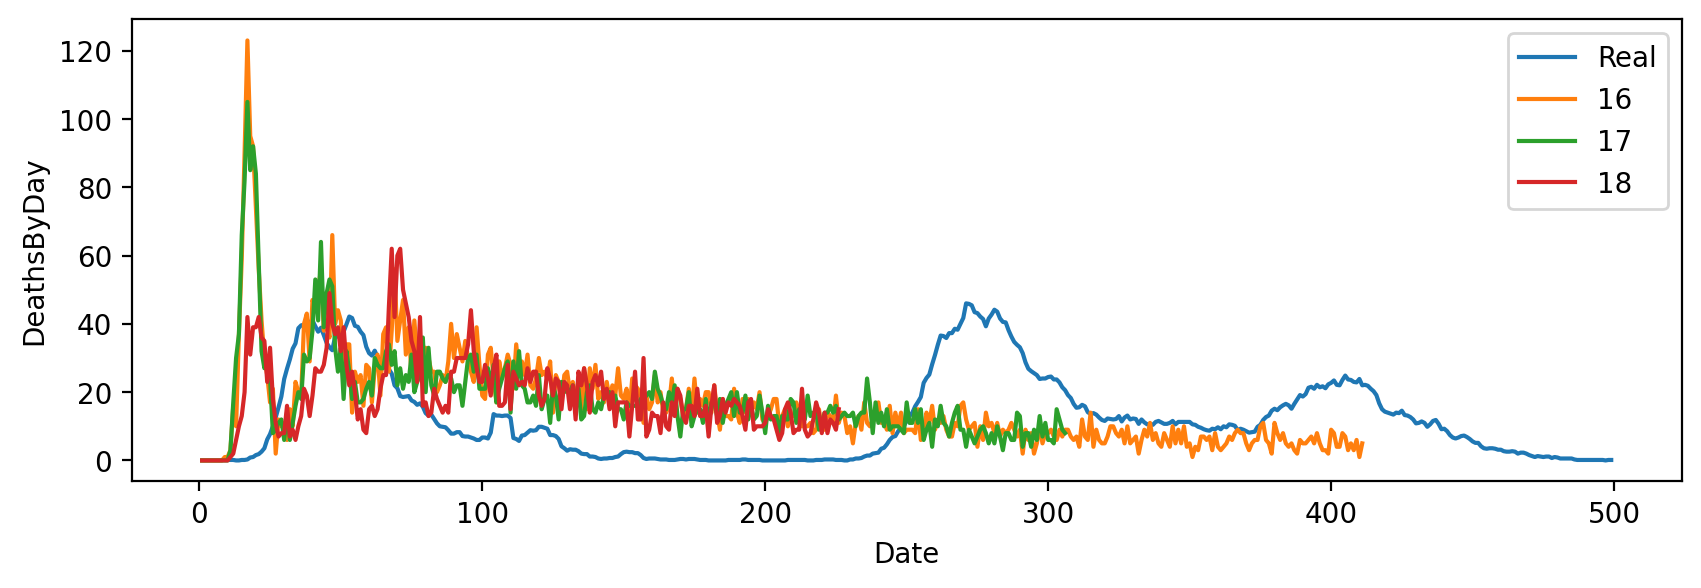

In [32]:
start_date, end_date = get_data_range(turin_data['Date'][0], 500)

plot_compare_real_sims(turin_data, sims_data, 'DeathsByDay', simulations_to_compare  ,start_date, end_date)

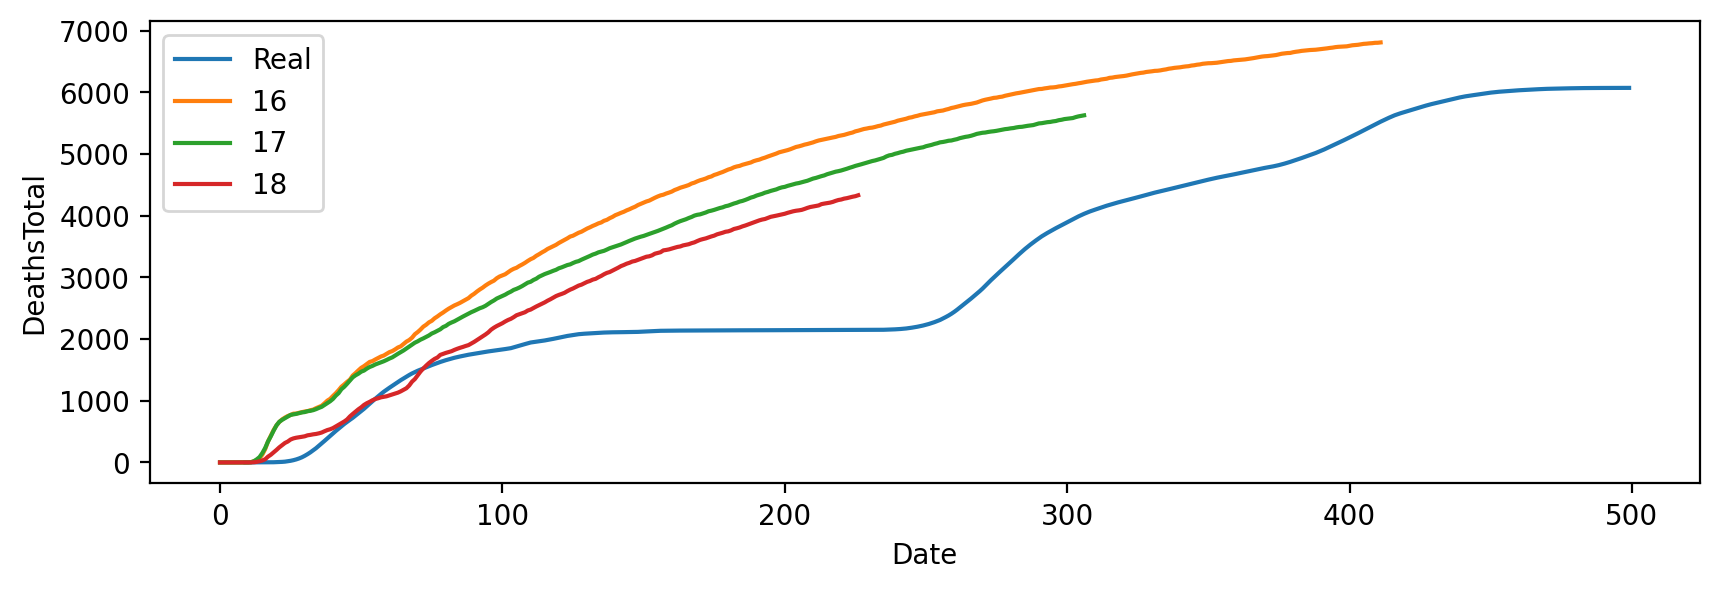

In [33]:
plot_compare_real_sims(turin_data, sims_data, 'DeathsTotal', simulations_to_compare  ,start_date, end_date)

## Positives

# Simulation Analysis
Here we have an overall analysis of only data coming from the simulations